In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


In [27]:
#ODE - IVP:
vf = lambda x: x*(1-x)
y0 = 0.01

#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))

#Prior
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
sigma = 1.0
Q = lambda h: sigma**2 * np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])
mu_0 = X_0
Sigma_0 = np.eye(3)*0.

#Discretization
t0, t1 = 0.0, 10.0
N = 18
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
t = np.linspace(t0,t1, 100)
h = (t1 - t0) / N


#Consequences of constant step size
A_h = A(h)
Q_h = Q(h)
b_h = np.zeros(3)
R_h = np.array([[0.0]])

#Measurement operator
g = lambda X: np.array([X[1] - vf(X[0])])
jacobian_g = lambda X: np.array([[-1*X[0]*(1 - 2*X[0]), 1, 0]])

#Data
z_sequence = np.zeros(N).reshape(-1,1)

In [28]:
#single step of a kalman filter
def ekf1_filter_step(A_t, b_t, Q_t, R_t, mu_t, Sigma_t, g, jacobian_g, z_observed):

    m_pred, P_pred = marginalization(A_t, b_t, Q_t, mu_t, Sigma_t)

    #linearize the observation model
    H_t = jacobian_g(m_pred)
    c_t = g(m_pred) - H_t @ m_pred

    # predict/estimate the next observationm: p(z_n|x_n)
    #z_expected, S_sqr = sqr_marginalization(H_n, c, R_h, m_next, P_next_sqr)

    #compute backward transition: p(z_n|x_n)
    #this actually implicitly first computes the observation estimate which is why the above line is commented

    #observe z:
    m_updated, P_updated = inversion(H_t, c_t, R_t, m_pred, P_pred, z_observed)
    
    return (m_pred, P_pred), (m_updated, P_updated)

In [29]:
#complete forward kalman filtering pass:
m_sequence = [mu_0]
P_sequence = [Sigma_0] 
m_predictions = []
P_predictions = []

for i in range(N):
    #this index correspnds to the timestep 
    #print(ts[i+1])
    #h = ts[i+1]-ts[i]
    (m_pred_nxt, P_pred_nxt), (m_nxt, P_nxt) = ekf1_filter_step(A_h, b_h, Q_h, R_h, m_sequence[-1], P_sequence[-1], g, jacobian_g, z_sequence[i,:])
    m_sequence.append(m_nxt)
    P_sequence.append(P_nxt)
    m_predictions.append(m_pred_nxt)
    P_predictions.append(P_pred_nxt)


In [30]:
m_sequence = np.array(m_sequence)
P_sequence = np.array(P_sequence)
m_predictions = np.array(m_predictions)
P_predictions = np.array(P_predictions)

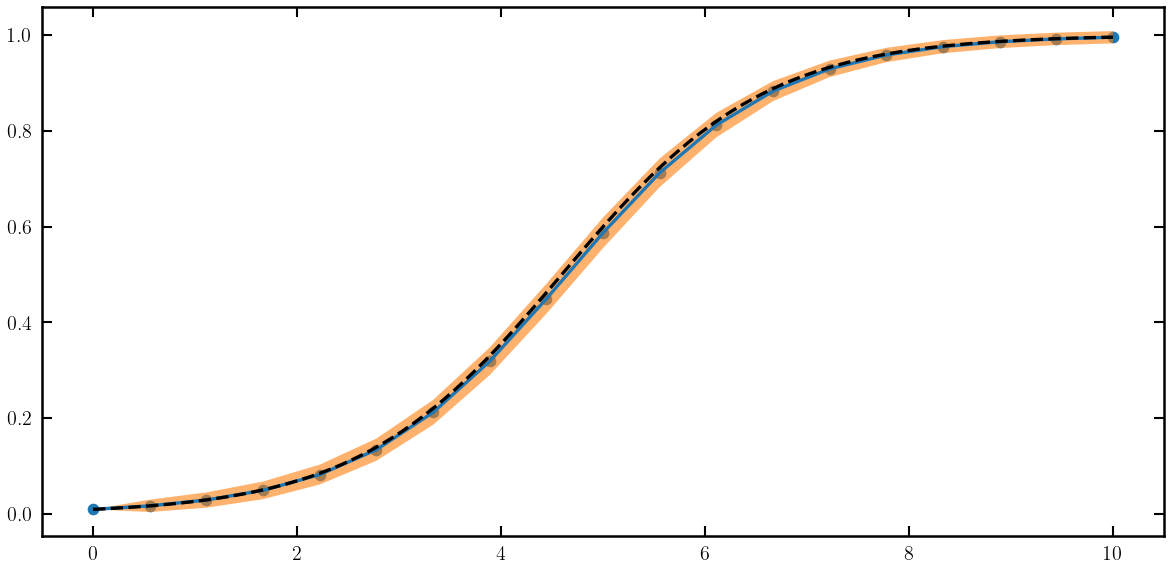

In [31]:
plt.figure(figsize=(10,5))
plt.plot(ts, m_sequence[:,0])
plt.plot(t, x_exact(t), linestyle='--', color="black")
plt.scatter(ts, m_sequence[:,0])
plt.fill_between(ts,m_sequence[:,0]-np.sqrt(P_sequence[:,0,0]), m_sequence[:,0]+np.sqrt(P_sequence[:,0,0]), alpha=0.6)
plt.show()